### Solve IK for `Common-Rig`

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2R,r2quat,get_uv_dict_nc,get_p_target_nc
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.7]


### Parse `scene_common_rig_psyonic.xml`

In [2]:
xml_path = '../asset/common_rig/scene_common_rig_psyonic_aux.xml'
env = MuJoCoParserClass(name='Common-Rig',rel_xml_path=xml_path,VERBOSE=True)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    body_idx = env.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs:
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]
print ("Done.")

dt:[0.0050] HZ:[200]
n_dof (=nv):[85]
n_geom:[74]
geom_names:['base', 'root2spine', 'spine2neck', 'neck2rclavicle', 'neck2lclavicle', 'neck2head', 'rclavicle2rshoulder', 'rshoulder2relbow', 'relbow2rwrist', 'rwrist2rtbase', 'rwrist2ribase', 'rwrist2rmbase', 'rwrist2rrbase', 'rwrist2rpbase', 'rtbase2rthumb', 'rthumb_l12', 'rthumb_l23', 'rthumb_l3end', 'ribase2rindex', 'rindex_l12', 'rindex_l23', 'rindex_l3end', 'rmbase2rmiddle', 'rmiddle_l12', 'rmiddle_l23', 'rmiddle_l3end', 'rmbase2rring', 'rring_l12', 'rring_l23', 'rring_l3end', 'rmbase2rpinky', 'rpinky_l12', 'rpinky_l23', 'rpinky_l3end', 'lclavicle2lshoulder', 'lshoulder2lelbow', 'lelbow2lwrist', 'lwrist2ltbase', 'lwrist2libase', 'lwrist2lmbase', 'lwrist2lrbase', 'lwrist2lpbase', 'ltbase2lthumb', 'lthumb_l12', 'lthumb_l23', 'lthumb_l3end', 'libase2lindex', 'lindex_l12', 'lindex_l23', 'lindex_l3end', 'lmbase2lmiddle', 'lmiddle_l12', 'lmiddle_l23', 'lmiddle_l3end', 'lrbase2lring', 'lring_l12', 'lring_l23', 'lring_l3end', 'lpbase2lpinky

### Parse bvh (Single Frame)

In [3]:
# code edited from https://github.com/tekulvw/bvh-converter

from bvh.skeleton import process_bvhfile, process_bvhkeyframe

mocap = process_bvhfile("../data/bvh/VAAI_DIRECT_15_02_a_M1.bvh", DEBUG=False)

print("Analyzing frames...")
for i in range(mocap.frames):
    new_frame = process_bvhkeyframe(mocap.keyframes[i], mocap.root, mocap.dt * i)
print("done")

pos_header, pos = mocap.get_frames_worldpos()
rot_header, rot = mocap.get_frames_rotations()

num_frames = mocap.frames
num_joints = len(mocap.get_frame(0))

p_full = np.zeros((num_frames, num_joints, 3))
r_full = np.zeros((num_frames, num_joints, 3))
timesteps = np.zeros(num_frames)

for i in range(num_frames):
    timesteps[i] = i * mocap.dt
    for j in range(num_joints):
        p_full[i,j,:] = np.array(pos[i][3*j+1:3*j+4]) / 100
        r_full[i,j,:] = np.array(rot[i][3*j+1:3*j+4])

p_full[:,:,1] *= -1
p_full = p_full[:,:,[1,0,2]]
r_full[:,:,1] *= -1
r_full = r_full[:,:,[1,0,2]]

frame_number = 45
p = p_full[frame_number]
r = r_full[frame_number]

uv_dict = get_uv_dict_nc(p)
p_target = get_p_target_nc(p, uv_dict)

Analyzing frames...
done


### Set IK targets

In [4]:
# Initialize MuJoCo viewer
env.init_viewer(viewer_title='Common-Rig',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=2.6,elevation=-25,lookat=[0.0,0.0,0.83])
env.reset()

# Set which joints to control
ctrl_joint_names = env.ctrl_names # <==
joint_idxs_fwd = env.get_idxs_fwd(joint_names=ctrl_joint_names)
joint_idxs_jac = env.get_idxs_jac(joint_names=ctrl_joint_names)
q_ctrl_init = env.get_qpos_joints(ctrl_joint_names)
n_ctrl_joint = len(ctrl_joint_names)

ik_body_names = ['right_pelvis','right_knee','right_ankle','left_pelvis','left_knee','left_ankle','spine','neck',
                 'right_shoulder','right_elbow','right_wrist','left_shoulder','left_elbow','left_wrist']

ik_right_hand_names = ['rthumb_l2','rthumb_l3','rthumb_end',
                       'rindex_l1','rindex_l2','rindex_l3','rindex_end',
                       'rmiddle_l1','rmiddle_l2','rmiddle_l3','rmiddle_end',
                       'rring_l1','rring_l2','rring_l3','rring_end',
                       'rpinky_l1','rpinky_l2','rpinky_l3','rpinky_end']

ik_left_hand_names =  ['lthumb_l2','lthumb_l3','lthumb_end',
                       'lindex_l1','lindex_l2','lindex_l3','lindex_end',
                       'lmiddle_l1','lmiddle_l2','lmiddle_l3','lmiddle_end',
                       'lring_l1','lring_l2','lring_l3','lring_end',
                       'lpinky_l1','lpinky_l2','lpinky_l3','lpinky_end']

ik_target_indices = [1,2,3,6,7,8,13,15,
                     17,18,19,45,46,47,
                     40,41,42,
                     35,36,37,38,
                     30,31,32,33,
                     25,26,27,28,
                     21,22,23,24,
                     68,69,70,
                     63,64,65,66,
                     58,59,60,61,
                     53,54,55,56,
                     48,49,50,51]

IK_Ps = [True]*len(ik_body_names)
IK_Rs = [False]*len(ik_body_names)

ik_p_trgts = []
ik_p_rh_trgts = []
ik_p_lh_trgts = []
ik_R_trgts = []

for body in ik_body_names:
    ik_p_trgts.append(p_target[body])

for right_hand in ik_right_hand_names:
    ik_p_rh_trgts.append(p_target[right_hand])

for left_hand in ik_left_hand_names:
    ik_p_lh_trgts.append(p_target[left_hand])

for i in ik_target_indices:
    ik_R_trgts.append(rpy2R(np.radians(r[i]),[2,1,0]))

### IK Process (Solve for body only -> Solve for hands)

Pressed ESC
Quitting.


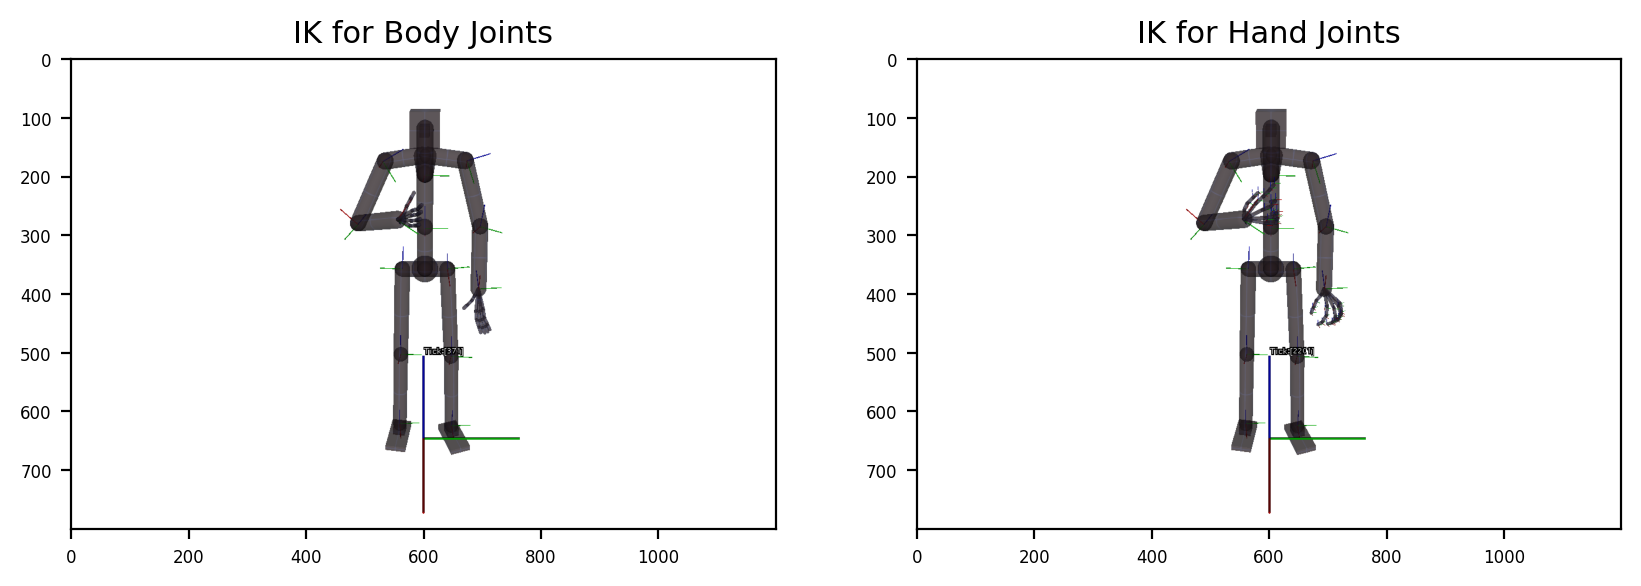

In [5]:
# Reset and loop 
q = q_ctrl_init.copy()
body_diff = 1e3

PERTURB_BASE_POSITION = True
if PERTURB_BASE_POSITION:
    jntadr = env.model.body('base').jntadr[0]
    qposadr = env.model.jnt_qposadr[jntadr]
    base_pos = p[0] # modify base position
    env.data.qpos[qposadr:qposadr+3] = base_pos
    env.data.qpos[qposadr+3:qposadr+7] = r2quat(rpy2R(np.radians(r[0] - [90,0,0]),[0,1,2]))

prev_q_pos = env.data.qpos.copy()
FIRST_FLAG = True
while body_diff > 1e-4:

    # Solve inverse kinematics for body
    J_list,ik_err_list = [],[]
    for ik_idx,ik_body_name in enumerate(ik_body_names):
        ik_p_trgt = ik_p_trgts[ik_idx]
        ik_R_trgt = ik_R_trgts[ik_idx]
        IK_P = IK_Ps[ik_idx]
        IK_R = IK_Rs[ik_idx]
        J,ik_err = env.get_ik_ingredients(
            body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
            IK_P=IK_P,IK_R=IK_R)
        J_list.append(J)
        ik_err_list.append(ik_err)
    J_stack      = np.vstack(J_list)
    ik_err_stack = np.hstack(ik_err_list)
    dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
    q = q + dq[joint_idxs_jac]
    q_rev = q[0:37].copy()
    np.clip(q_rev, env.ctrl_joint_mins[0:37], env.ctrl_joint_maxs[0:37], out=q_rev)
    q[0:37] = q_rev.copy()
    
    # FK
    env.data.qpos[joint_idxs_fwd] = q
    q_env = env.data.qpos.copy()
    body_diff = np.linalg.norm(q_env - prev_q_pos)

    env.forward(q=q_env,INCREASE_TICK=True)
    prev_q_pos=q_env.copy()
    
    if env.loop_every(tick_every=10):
        # Plot world frame
        env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                   PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
        
        # Text information
        env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3),PLOT_AXIS=False,
                   label='Tick:[%d]'%(env.tick))
        
        # Plot bodies
        env.plot_body_T(body_name='base',PLOT_AXIS=False,axis_len=0.5,axis_width=0.01)
        for body_name in env.body_names:
            p,R = env.get_pR_body(body_name=body_name)
            env.plot_T(p=p,R=R,PLOT_AXIS=False,axis_len=0.05,axis_width=0.005)
            
        # Plot IK target
        for ik_idx,ik_body_name in enumerate(ik_body_names):
            ik_p_trgt = ik_p_trgts[ik_idx]
            ik_R_trgt = ik_R_trgts[ik_idx]
            env.plot_T(p=ik_p_trgt,R=ik_R_trgt,
                       PLOT_AXIS=True,axis_len=0.1,axis_width=0.002)

        env.render()

right_wrist_pos = env.get_p_body(body_name='right_wrist')
left_wrist_pos = env.get_p_body(body_name='left_wrist')
hand_diff = 1e3

while env.is_viewer_alive():

    # Solve inverse kinematics for body
    J_list,ik_err_list = [],[]
    for ik_idx,ik_body_name in enumerate(ik_body_names):
        ik_p_trgt = ik_p_trgts[ik_idx]
        ik_R_trgt = ik_R_trgts[ik_idx]
        IK_P = IK_Ps[ik_idx]
        IK_R = IK_Rs[ik_idx]
        J,ik_err = env.get_ik_ingredients(
            body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
            IK_P=IK_P,IK_R=IK_R)
        J_list.append(J)
        ik_err_list.append(ik_err)
    J_stack      = np.vstack(J_list)
    ik_err_stack = np.hstack(ik_err_list)
    dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
    q = q + dq[joint_idxs_jac]

    # Solve inverse kinematics for right hand
    J_rh_list,ik_err_rh_list = [],[]
    for ik_rh_idx,ik_right_hand_name in enumerate(ik_right_hand_names):
        ik_p_trgt = ik_p_rh_trgts[ik_rh_idx] + right_wrist_pos
        ik_R_trgt = ik_R_trgts[ik_rh_idx+len(ik_body_names)]
        IK_P = True
        IK_R = False
        J,ik_err = env.get_ik_ingredients(
            body_name=ik_right_hand_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
            IK_P=IK_P,IK_R=IK_R)
        J_rh_list.append(J)
        ik_err_rh_list.append(ik_err)
    J_stack      = np.vstack(J_rh_list)
    ik_err_stack = np.hstack(ik_err_rh_list)
    dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
    q = q + dq[joint_idxs_jac]
    q_rev = q[37:77].copy()
    np.clip(q_rev, env.ctrl_joint_mins[37:77], env.ctrl_joint_maxs[37:77], out=q_rev)
    q[37:77] = q_rev.copy()

    # Solve inverse kinematics for left hand
    J_lh_list,ik_err_lh_list = [],[]
    for ik_lh_idx,ik_left_hand_name in enumerate(ik_left_hand_names):
        ik_p_trgt = ik_p_lh_trgts[ik_lh_idx] + left_wrist_pos
        ik_R_trgt = ik_R_trgts[ik_lh_idx+len(ik_body_names)+len(ik_right_hand_names)]
        IK_P = True
        IK_R = False
        J,ik_err = env.get_ik_ingredients(
            body_name=ik_left_hand_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
            IK_P=IK_P,IK_R=IK_R)
        J_lh_list.append(J)
        ik_err_lh_list.append(ik_err)
    J_stack      = np.vstack(J_lh_list)
    ik_err_stack = np.hstack(ik_err_lh_list)
    dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
    q = q + dq[joint_idxs_jac]
    q_rev = q[37:77].copy()
    np.clip(q_rev, env.ctrl_joint_mins[37:77], env.ctrl_joint_maxs[37:77], out=q_rev)
    q[37:77] = q_rev.copy()

    # FK
    env.data.qpos[joint_idxs_fwd] = q
    q_current = env.data.qpos.copy()
    hand_diff = np.linalg.norm(q_current - prev_q_pos)

    env.forward(q=q_current,INCREASE_TICK=True)
    prev_q_pos = q_current.copy()
    
    if env.loop_every(tick_every=10):
        # Plot world frame
        env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                   PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
        
        # Text information
        env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3),PLOT_AXIS=False,
                   label='Tick:[%d]'%(env.tick))
        
        # Plot bodies
        env.plot_body_T(body_name='base',PLOT_AXIS=False,axis_len=0.5,axis_width=0.01)
        for body_name in env.body_names:
            p,R = env.get_pR_body(body_name=body_name)
            env.plot_T(p=p,R=R,PLOT_AXIS=False,axis_len=0.05,axis_width=0.005)
            
        # Plot IK target
        for ik_idx,ik_body_name in enumerate(ik_body_names+ik_right_hand_names+ik_left_hand_names):
            ik_p_trgt = (ik_p_trgts+ik_p_rh_trgts+ik_p_lh_trgts)[ik_idx]
            ik_R_trgt = ik_R_trgts[ik_idx]
            # env.plot_body_T(body_name=ik_body_name,
                            # PLOT_AXIS=True,axis_len=0.2,axis_width=0.01)
            if ik_idx < 14:
                env.plot_T(p=ik_p_trgt,R=ik_R_trgt,
                           PLOT_AXIS=True,axis_len=0.1,axis_width=0.002)
            elif ik_idx < 33:
                env.plot_T(p=(ik_p_trgt+right_wrist_pos),R=ik_R_trgt,
                           PLOT_AXIS=True,axis_len=0.025,axis_width=0.001)
            else:
                env.plot_T(p=(ik_p_trgt+left_wrist_pos),R=ik_R_trgt,
                           PLOT_AXIS=True,axis_len=0.025,axis_width=0.001)
        env.render()

    # Save image
    if env.is_viewer_alive() and FIRST_FLAG:
        scene_img_init = env.grab_image()
    if env.is_viewer_alive() and env.loop_every(tick_every=100):
        scene_img_final = env.grab_image()
    FIRST_FLAG = False

# Close MuJoCo viewer
env.close_viewer()

# Plot initial and final scenes
fig,axs = plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(top=0.85,bottom=0.15,wspace=0.2,hspace=0.5)
axs[0].imshow(scene_img_init)
axs[0].set_title('IK for Body Joints',fontsize=11)
axs[1].imshow(scene_img_final)
axs[1].set_title('IK for Hand Joints',fontsize=11)
plt.show()

In [6]:
xml_path = '../asset/common_rig/scene_common_rig_hand.xml'
env2 = MuJoCoParserClass(name='Common-Rig',rel_xml_path=xml_path,VERBOSE=False)
# Modify the color of body exluding 'world'
for body_name in env2.body_names:
    if body_name in ['world']: continue
    body_idx = env2.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env2.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs:
        env2.model.geom(geom_idx).rgba = [0.7,0.7,0.7,0.5]

hand_names = ['rthumb_l1','rthumb_l2','rthumb_l3','rthumb_end',
              'rindex_l0','rindex_l1','rindex_l2','rindex_l3','rindex_end',
              'rmiddle_l0','rmiddle_l1','rmiddle_l2','rmiddle_l3','rmiddle_end',
              'rring_l0','rring_l1','rring_l2','rring_l3','rring_end',
              'rpinky_l0','rpinky_l1','rpinky_l2','rpinky_l3','rpinky_end',
              'lthumb_l1','lthumb_l2','lthumb_l3','lthumb_end',
              'lindex_l0','lindex_l1','lindex_l2','lindex_l3','lindex_end',
              'lmiddle_l0','lmiddle_l1','lmiddle_l2','lmiddle_l3','lmiddle_end',
              'lring_l0','lring_l1','lring_l2','lring_l3','lring_end',
              'lpinky_l0','lpinky_l1','lpinky_l2','lpinky_l3','lpinky_end']
for hand_name in hand_names:
    hand_idx = env2.body_names.index(hand_name)
    geom_idxs = [idx for idx,val in enumerate(env2.model.geom_bodyid) if val==hand_idx]
    for geom_idx in geom_idxs:
        env2.model.geom(geom_idx).rgba = [1,0,0,0.7]
print ("Done.")

Done.


In [7]:
def normalize(angle):
	return np.arctan2(np.sin(angle),np.cos(angle))

q_pos = np.array(env.data.qpos.copy())
print(q_pos.shape)

q_pos2 = np.zeros_like(env2.data.qpos)
print(q_pos2.shape)

aux_idx = list(range(0,86))
for i in (21,25,29,33,37,49,53,57,61,65):
    aux_idx.remove(i)

q_pos2 = q_pos[aux_idx]
q_pos2 = normalize(q_pos2)

q_couple = q_pos2.copy()

coupled_joint_idx_list = [[22,23],[24,25,26],[27,28,29],[30,31,32],[33,34,35],
                          [45,46],[47,48,49],[50,51,52],[53,54,55],[56,57,58]]

coupled_joint_weights_list = [[1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2],
                              [1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2]]

for i in range(len(coupled_joint_idx_list)):
    coupled_joint_idx = coupled_joint_idx_list[i]
    coupled_joint_weights = coupled_joint_weights_list[i]
    joint_sum = 0

    for j in range(len(coupled_joint_idx)):
        joint_sum += q_pos2[coupled_joint_idx[j]]

    joint_sum /= np.sum(coupled_joint_weights)

    for k in range(len(coupled_joint_idx)):
        q_couple[coupled_joint_idx[k]] = joint_sum*coupled_joint_weights[k]

# q_couple[21:36] = 0
# q_couple[44:59] = 0

(86,)
(76,)


In [8]:
s = np.random.normal(0,30,44)
joint_idx = list(np.arange(14,36)) + list(np.arange(37,59))
q_couple[joint_idx] = np.radians(s)

In [9]:
# q_inpaint = np.load('../data/15a_inpaint.npy')
# q_inpaint = q_inpaint[200,:]

# q_couple = q_inpaint.copy()

# coupled_joint_idx_list = [[22,23],[24,25,26],[27,28,29],[30,31,32],[33,34,35],
#                           [45,46],[47,48,49],[50,51,52],[53,54,55],[56,57,58]]

# coupled_joint_weights_list = [[1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2],
#                               [1,1],[1,3,2],[1,3,2],[1,3,2],[1,3,2]]

# for i in range(len(coupled_joint_idx_list)):
#     coupled_joint_idx = coupled_joint_idx_list[i]
#     coupled_joint_weights = coupled_joint_weights_list[i]
#     joint_sum = 0

#     for j in range(len(coupled_joint_idx)):
#         joint_sum += q_pos2[coupled_joint_idx[j]]

#     joint_sum /= np.sum(coupled_joint_weights)

#     for k in range(len(coupled_joint_idx)):
#         q_couple[coupled_joint_idx[k]] = joint_sum*coupled_joint_weights[k]

# q_couple[q_inpaint==0] = q_pos2[q_inpaint==0]

In [10]:
env2.init_viewer(viewer_title='Common-Rig',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env2.update_viewer(azimuth=180,distance=2.6,elevation=-25,lookat=[0.0,0.0,0.83])
env2.reset()

while env2.is_viewer_alive():
    env2.forward()
    env2.data.qpos[:] = q_couple
    env2.render()

Pressed ESC
Quitting.
